In [35]:
import os
from scipy.io import wavfile
import sklearn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from keras.layers import Conv2D, MaxPool2D, Flatten, LSTM
from keras.layers import Dropout, Dense, TimeDistributed
from keras.models import Sequential
from keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight as sklearn_compute_class_weight
from tqdm import tqdm
from python_speech_features import mfcc

In [36]:
def get_conv_model():
    model = Sequential()
    model.add(Conv2D(16, (3,3), activation='relu', strides=(1,1), padding='same', input_shape=input_shape))
    model.add(Conv2D(32, (3,3), activation='relu', strides=(1,1), padding='same'))
    model.add(Conv2D(64, (3,3), activation='relu', strides=(1,1), padding='same'))
    model.add(Conv2D(128, (3,3), activation='relu', strides=(1,1), padding='same'))
    model.add(MaxPool2D((2,2)))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(128, activation='relu')) 
    model.add(Dense(64, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    model.summary()
    model.compile(loss='categorical_crossentropy', 
                  optimizer='adam',
                  metrics=['acc'])
    return model

In [37]:
class Config:
    def __init__(self, mode='conv', nfilt=26, nfeat=13, nfft=512, rate=16000): 
        self.mode = mode
        self.nfilt = nfilt
        self.nfeat = nfeat
        self.nfft = nfft
        self.rate = rate
        self.step = int(rate/10)

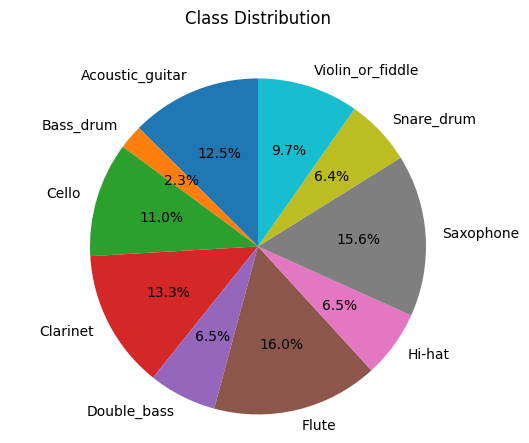

In [38]:
#Model Preparation
df = pd.read_csv('instruments.csv')
df.set_index('fname', inplace=True)

for f in df.index:
    rate, signal = wavfile.read('clean/'+f)
    df.at[f, 'length'] = signal.shape[0]/rate

classes = list(np.unique(df.label))
class_dist = df.groupby(['label'])['length'].mean()

n_samples = 2 * int(df['length'].sum()/0.1) 
prob_dist = class_dist / class_dist.sum()
choices = np.random.choice(class_dist.index, p=prob_dist)

fig, ax = plt.subplots()
ax.set_title('Class Distribution', y=1.08)
ax.pie(class_dist, labels=class_dist.index, autopct='%1.1f%%',
       shadow=False, startangle=90)
ax.axis('equal')
plt.show()

In [39]:
def build_rand_feat() :
    X = []
    y = []
    _min, _max = float('inf'), -float('inf')
    for _ in tqdm(range(n_samples)):
        rand_class = np.random.choice(class_dist.index, p = prob_dist)
        file = np.random.choice(df[df.label==rand_class].index)
        rate, wav = wavfile.read('clean/'+file)
        label = df.at[file, 'label']
        rand_index = np.random.randint(0, wav.shape[0]-config.step)
        sample = wav[rand_index:rand_index+config.step]
        X_sample = mfcc(sample ,rate ,numcep=config.nfeat, nfilt=config.nfilt, nfft=config.nfft).T

        _min = min(np.amin(X_sample), _min)
        _max = max(np.amax(X_sample), _max)
        X.append(X_sample if config.mode == 'conv' else X_sample.T)
        y.append(classes.index(label))
    X, y = np.array(X), np.array(y)
    X = (X - _min) / (_max - _min)
    if config.mode == 'conv':
        X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)
    elif config.mode == 'time':
        X = X.reshape(X.shape[0], X.shape[1], X.shape[2])
    y = to_categorical(y, num_classes=10)
    return X, y

In [41]:
config = Config(mode='conv')
if config.mode == 'conv':
    X, y = build_rand_feat()
    y_flat = np.argmax(y,axis=1)
    input_shape = (X.shape[1], X.shape[2], 1)
    model = get_conv_model()

elif config.mode == 'time':
    X, y = build_rand_feat()
    y_flat = np.argmax(y,axis=1)
    input_shape = (X.shape[1], X.shape[2], 1)
    model = get_recurrent_model()

from collections import Counter

class_counts = Counter(y_flat)
total_samples = len(y_flat)
class_weights = {class_label: total_samples / class_count for class_label, class_count in class_counts.items()}

#class_weights = sklearn_compute_class_weight('balanced', np.unique(y_flat), y_flat)

model.fit(X,y, epochs=10, batch_size=32, shuffle = True, class_weight=class_weights)

100%|██████████| 26404/26404 [00:32<00:00, 803.04it/s]


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 13, 9, 16)         160       
                                                                 
 conv2d_29 (Conv2D)          (None, 13, 9, 32)         4640      
                                                                 
 conv2d_30 (Conv2D)          (None, 13, 9, 64)         18496     
                                                                 
 conv2d_31 (Conv2D)          (None, 13, 9, 128)        73856     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 6, 4, 128)        0         
 2D)                                                             
                                                                 
 dropout_7 (Dropout)         (None, 6, 4, 128)         0         
                                                      